In [1]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

2022-05-19 11:45:03.405636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
img_height, img_width = 256, 256
batch_size = 128

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/home/alexanderk/Documents/Datasets/selfmotion_imgs',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 20537 files belonging to 1 classes.


2022-05-19 11:45:57.254050: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-19 11:45:57.254873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-19 11:45:57.298522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-05-19 11:45:57.298550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-19 11:45:57.301685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-19 11:45:57.301750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

2022-05-19 11:46:18.234173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-19 11:46:18.254870: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3499910000 Hz


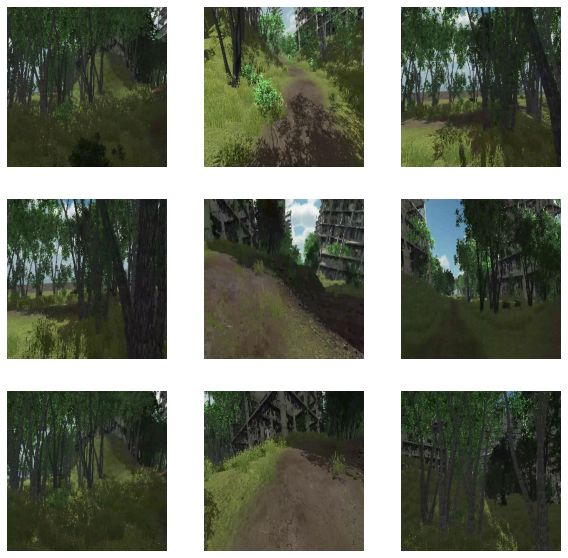

In [6]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [8]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [9]:
print(np.min(first_image), np.max(first_image)) 

0.0 0.8450368


In [10]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [11]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [12]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
  
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
 

    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [13]:
enc = encoder(input_encoder)

In [14]:
# enc.save('vae-cartoon-enc.h5')

In [15]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 128, 128, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 128, 128, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

In [16]:
input_1 = (200,)
input_2 = (200,)

In [17]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [18]:
final = sampling(input_1,input_2)

In [19]:
# final.save('sampling-cartoon.h5')

In [20]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [21]:
dec = decoder(input_decoder)

In [22]:
# dec.save('vae-cartoon-dec.h5')

In [23]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        3692

In [24]:
#model.layers[1].get_weights()

In [25]:
#model.save('autoencoder.h5')

In [26]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

In [28]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss = kl_loss(mean, log_var)
    return  r_loss + kl_loss

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [30]:
os.makedirs('tf_vae/scene_imgs/training_weights', exist_ok=True)
os.makedirs('tf_vae/scene_imgs/images', exist_ok=True)

In [31]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/scene_imgs/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/scene_imgs/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [32]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('tf_vae/scene_imgs/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [36]:
train(normalized_ds, 30)

UnboundLocalError: in user code:

    /tmp/ipykernel_9543/144731484.py:11 train_step  *
        loss = vae_loss(images, generated_images, mean, log_var)
    /tmp/ipykernel_9543/1158293847.py:11 vae_loss  *
        kl_loss = kl_loss(mean, log_var)

    UnboundLocalError: local variable 'kl_loss' referenced before assignment


In [34]:
#enc.load_weights('../tf_vae/scene_imgs/training_weights/enc_29.h5')

In [35]:
#dec.load_weights('../tf_vae/scene_imgs/training_weights/dec_29.h5')

In [26]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > 5000:
        break

In [27]:
embeddings.shape

(5120, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

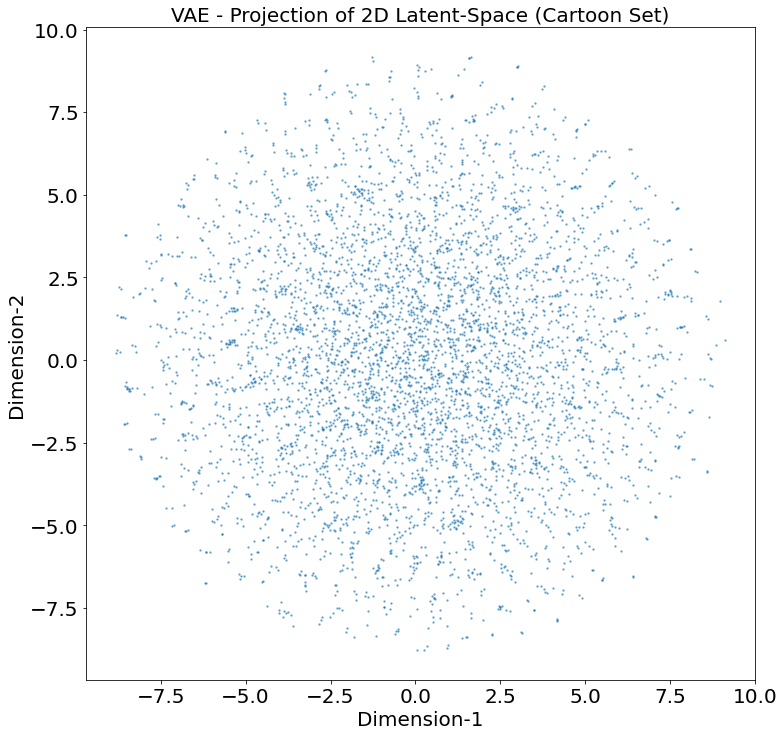

In [29]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("VAE - Projection of 2D Latent-Space (Cartoon Set)", size=20)
plt.show()

In [30]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

In [31]:
reconstruction.shape

(5120, 256, 256, 3)

## Reconstructing Test Images

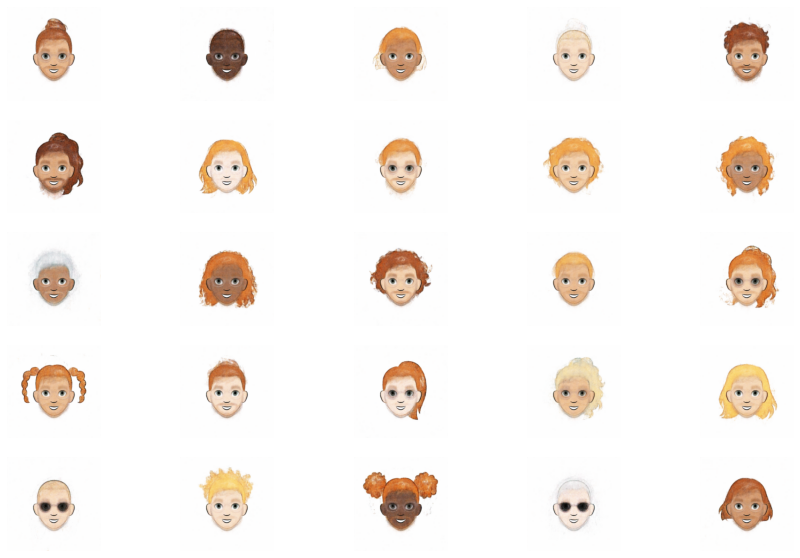

In [32]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

## Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

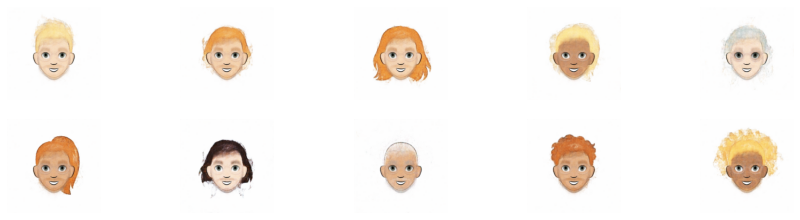

In [30]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

(10, 200)


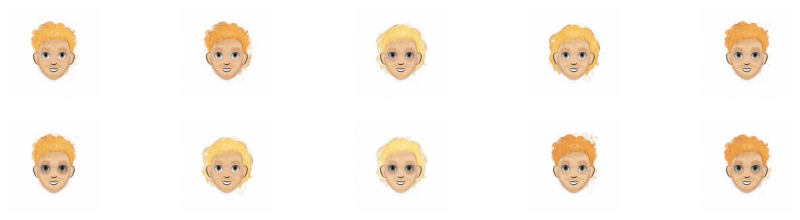

In [32]:
figsize = 15


min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)